This file is a testing playground/sandbox for the usage of audio processing libraries in Python

In [ ]:
!pip install essentia

     |████████████████████████████████| 13.7 MB 4.8 MB/s 


In [ ]:
!pip install pyacoustid

  Created wheel for pyacoustid: filename=pyacoustid-1.2.2-py3-none-any.whl size=12721 sha256=2a5a91c9f63ee979479aa0893584a675f24e95d756dc78ce5aa01fadd26dc30c
  Stored in directory: /root/.cache/pip/wheels/b6/a1/91/8bbc87bede2c41e1a13dbdabb5294177a27040a11876ebc320
Successfully built pyacoustid


In [ ]:
import essentia
from essentia.standard import *
import acoustid as ai
import chromaprint as ch
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
!pip install wavio

In [ ]:
# This takes in a string `filename` and outputs a list of numbers which indicates 
# the audio fingerprint (can be used for graphing)

def getFingerprint(filename):
  audio = es.MonoLoader(filename=filename, sampleRate=44100)()
  plot(audio)
  fingerprint = es.Chromaprinter()(audio)
  c = bytes(fingerprint, "utf_8")
  print(filename, c)
  fp, v = ch.decode_fingerprint(c)
  return fp

fingerprint1 = getFingerprint('./L1C2V1 (mp3cut.net).mp3')
fingerprint2 = getFingerprint('./L1C2V1.mp3')
#fingerprint3 = getFingerprint('./L1L1V1.mp3')

# audio1 = es.MonoLoader(filename='./L1R1V1.mp3', sampleRate=44100)()
# audio2 = es.MonoLoader(filename='./L1L1V1.mp3', sampleRate=44100)()
# fingerprint = es.Chromaprinter()(audio1)
# c = bytes(fingerprint, "utf_8")
# print(c)
# fp1, v = ch.decode_fingerprint(c)

# fingerprint = es.Chromaprinter()(audio2)
# c = bytes(fingerprint, "utf_8")
# print(c)
# g, v = ch.decode_fingerprint(c)
# g = to_str(g)
# s = "\n".join(g)
# f2.write(s)
# f2.close()
# duration, fp_encoded = ai.fingerprint_file('./original/au2 (5cm right).mp3')
# f, version = ch.decode_fingerprint(fp_encoded)

# print(f, version)
#https://essentia.upf.edu/essentia_python_examples.html

NameError: ignored

In [ ]:
#ChromeCrossSimilarity
import essentia.standard as estd
from essentia.pytools.spectral import hpcpgram

daddyFilePath = './L1R1V1.mp3'
audio1 = es.MonoLoader(filename=daddyFilePath, sampleRate=32000)()
filePathAudio = ['./L1C1V1 (mp3cut.net).mp3', './L1C2V1 (mp3cut.net).mp3', 
            './L1C1V1.mp3', './L1C1V2.mp3', './L1C2V1.mp3', './L1C3V1.mp3',
             './L1L1V1.mp3', './L1L2V1.mp3', './L1L3V1.mp3', './L1R1V1.mp3',
             './L1R2V1.mp3', './L1R3V1.mp3', './L2C1V1.mp3', './L2C2V1.mp3',
             './L3C1V1.mp3', './L3C2V1.mp3', './L3C3V1.mp3'
            ]
audio1_hpcp = hpcpgram(audio1, sampleRate=32000)
print("Comparing with daddy path = " + daddyFilePath)
for i in range(len(filePathAudio)):
  audio2 = es.MonoLoader(filename = filePathAudio[i], sampleRate=32000)()
  audio2_hpcp = hpcpgram(audio2, sampleRate=32000)

  crp = estd.ChromaCrossSimilarity(frameStackSize=2,
                                  frameStackStride=1,
                                  binarizePercentile=0.9,
                                  oti=True)

  pair_crp = crp(audio1_hpcp, audio2_hpcp)

  score_matrix, distance = estd.CoverSongSimilarity(disOnset=0.5,
                                                    disExtension=0.5,
                                                    alignmentType='serra09',
                                                    distanceType='asymmetric')(pair_crp)
  print('Similarity distance: %s' % distance + "with " + filePathAudio[i])


NameError: ignored

In [ ]:
from scipy.signal import chirp, spectrogram
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write
import IPython
import wavio


def plot_spectrogram(title, w, fs):
    ff, tt, Sxx = spectrogram(w, fs=fs, nperseg=256, nfft=576)
    plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='gray_r', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()

samplerate = 44100; fs = 12000
t = np.linspace(0., 100., 44100);
print(t)
f0 = 10000
f1 = 2200000
t1=10
y = chirp(t, f0, f1, 1, method='linear')
plot_spectrogram("t43",y, fs)
amplitude = np.iinfo(np.int16).max
data = amplitude * np.sin(2. * np.pi * fs * t)
#  Test the recoded *.wav file

wavio.write("sine.wav", y, samplerate, sampwidth=3)
#write("chirp.wav", samplerate, y.astype(np.int16))
IPython.display.Audio('./sine.wav')


ModuleNotFoundError: ignored

In [ ]:
# Loading audio file
audio = MonoLoader(filename='./hiphop.mp3')()

# Phase 1: compute the onset detection function
# The OnsetDetection algorithm provides various onset detection functions. Let's use two of them.

od1 = OnsetDetection(method='hfc')
od2 = OnsetDetection(method='complex')

# Let's also get the other algorithms we will need, and a pool to store the results
w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
pool = essentia.Pool()

# Computing onset detection functions.
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mag, phase, = c2p(fft(w(frame)))
    pool.add('features.hfc', od1(mag, phase))
    pool.add('features.complex', od2(mag, phase))

# Phase 2: compute the actual onsets locations
onsets = Onsets()

onsets_hfc = onsets(# this algo expects a matrix, not a vector
                    essentia.array([ pool['features.hfc'] ]),

                    # you need to specify weights, but as there is only a single
                    # function, it doesn't actually matter which weight you give it
                    [ 1 ])

onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ])


# Mark onsets on the audio, which we'll write back to disk
# We use beeps instead of white noise and stereo signal as it's more distinctive

silence = [0.] * len(audio)

beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
AudioWriter(filename='audio/hiphop_onsets_hfc_stereo.mp3', format='mp3')(StereoMuxer()(audio, beeps_hfc))

beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)
AudioWriter(filename='audio/hiphop_onsets_complex_stereo.mp3', format='mp3')(StereoMuxer()(audio, beeps_complex))

RuntimeError: ignored

[ -33   27   -6 ...  183 -311  207]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


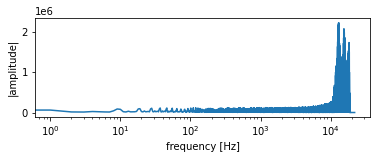

In [ ]:
#Creating amplitude vs frequency graph

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

wr = wave.open('16_C.wav', 'r')
sz = 44100 
da = np.fromstring(wr.readframes(sz), dtype=np.int16)
left, right = da[0::2], da[1::2]

lf, rf = abs(np.fft.rfft(left)), abs(np.fft.rfft(right))

plt.figure(1)
print(left)
x = np.arange(44100)/44100
plt.plot(x, left)
b = plt.subplot(212)
b.set_xscale('log')
b.set_xlabel('frequency [Hz]')
b.set_ylabel('|amplitude|')
plt.plot(lf)
#plt.savefig('sample-graph.png')


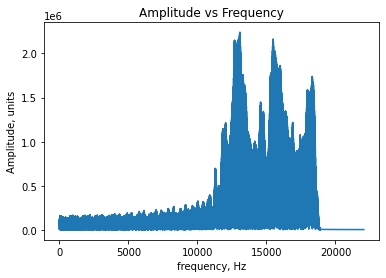

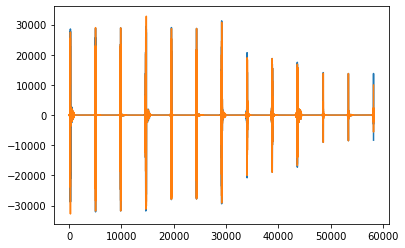

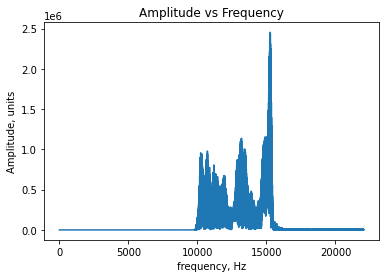

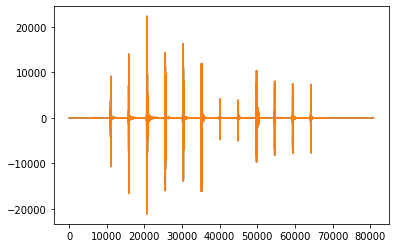

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn import preprocessing
from scipy.fftpack import fft
import matplotlib.pyplot as plt



def ampVsFreq(filename):
  plt.title('Amplitude vs Frequency')
  sampFreq, sound = wavfile.read(filename)
  signal = sound[:,0]

  fft_spectrum = np.fft.rfft(signal)
  freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)

  fft_spectrum_abs = np.abs(fft_spectrum)

  plt.plot(freq, fft_spectrum_abs)
  plt.xlabel("frequency, Hz")
  plt.ylabel("Amplitude, units")
  plt.show()

  plt.plot(sound)
  plt.show()


def ampVsSample(filename):
  sampFreq, sound = wavfile.read(filename)
  plt.title('Amplitude vs Sample index')
  plt.plot(sound)
  plt.xlabel('Sample')
  plt.ylabel('Amplitude')
  plt.show()

#ampVsSample('16_C.wav')
ampVsFreq('16_C.wav')
ampVsFreq('test3.wav')
#ampVsFreq('output.wav')

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


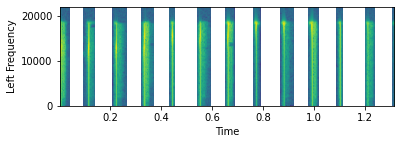

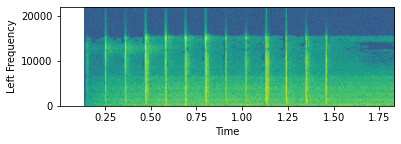

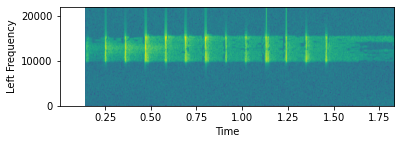

In [ ]:
#High-pass filter means removing frequency higher than a certain cutoff frequency
import matplotlib.pyplot as plot
import numpy
from scipy.io import wavfile
from scipy import signal
from scipy.signal import filtfilt
import wave


def specto(filename):
  samplingFrequency, signalData = wavfile.read(filename)

  audLeft = signalData[:,0] #selects only left

  plot.subplot(212)
  #plot.title('Left Spectogram')

  powerSpectrumL, frequenciesFoundL, timeL, imageAxisL = plot.specgram(audLeft, Fs=samplingFrequency) 
  plot.xlabel('Time')
  plot.ylabel('Left Frequency')

  plot.show()

def HighPassFilter(filename):
  samplingFrequency, signalData = wavfile.read(filename)
  
  nyquist = samplingFrequency // 2
  norm_cutoff = 10000 / nyquist
  
  b = signal.firwin(255, norm_cutoff, pass_zero=False)
  #newSignalData = signal.lfilter(b, [1.0], signalData)
  newSignalData = filtfilt(b, 1, signalData, axis=0)
  wavfile.write('test3.wav', samplingFrequency, newSignalData.astype(np.int16))
  
  specto('test3.wav');

def fft_ours(filename):
  sampFreq, sound = wavfile.read(filename)
  signal = sound[:,0]

  fft_spectrum = np.fft.rfft(signal)
  freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
  
ff = 'test.wav'
specto('16_C.wav')
specto(ff)
HighPassFilter(ff)


In [ ]:
!pip install sox

In [ ]:
import numpy as np
import wave
import sox

tfm = sox.Transformer()
tfm.trim(0.5,0.7)

tfm.build_file('16_C.wav', 'output.wav')

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
This install of SoX cannot process .wav files.
This install of SoX cannot process .wav files.


FileNotFoundError: ignored

In [ ]:
!pysox test3.wav -n noiseprof noise.prof

/bin/bash: pysox: command not found
